No consensus reached within max steps.


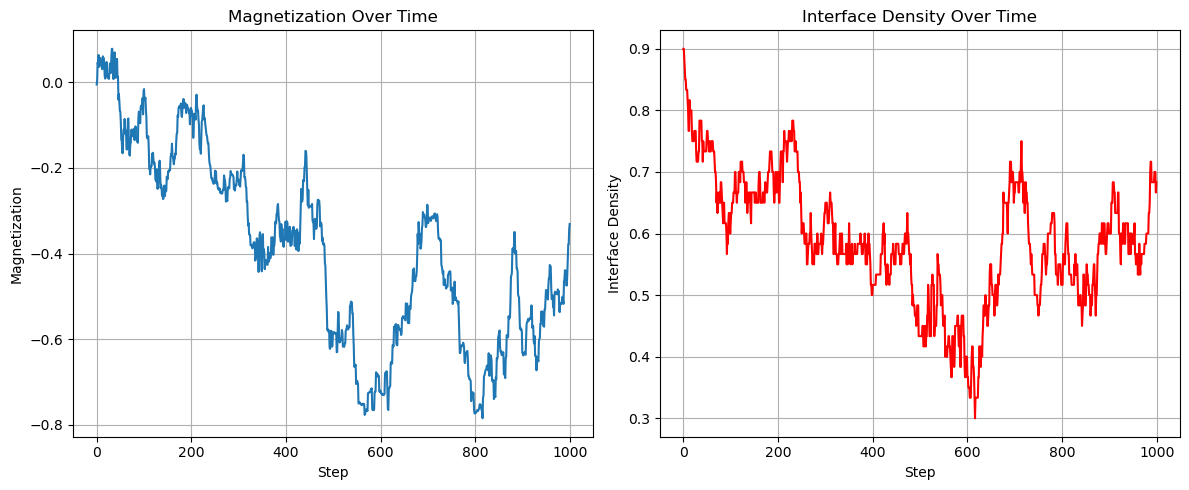

Saving animation to voter_model_simulation.mkv


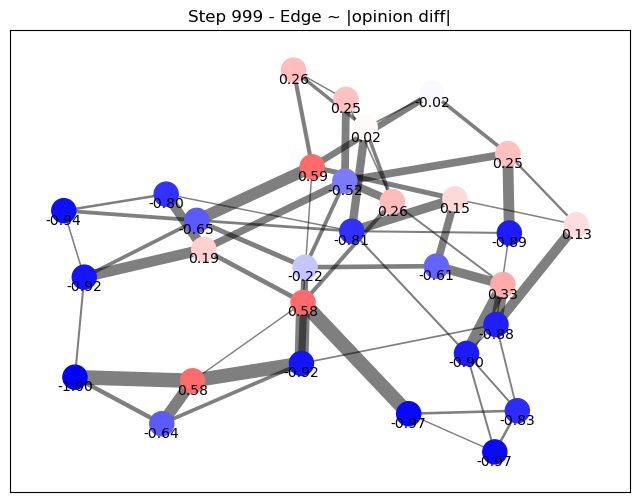

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

def create_network(topology, n):
    if topology == "random":
        return nx.erdos_renyi_graph(n, p=0.3)
    elif topology == "small_world":
        return nx.watts_strogatz_graph(n, k=4, p=0.3)
    elif topology == "scale_free":
        return nx.barabasi_albert_graph(n, m=2)
    else:
        raise ValueError("Unsupported topology")

def initialize_opinions(G):
    return {node: np.random.uniform(-1, 1) for node in G.nodes()}

def apply_noise(value, noise_strength=0.01, noise_type='normal'):
    if noise_type == 'normal':
        noise = np.random.normal(0, noise_strength)
    elif noise_type == 'uniform':
        noise = np.random.uniform(-noise_strength, noise_strength)
    elif noise_type == 'laplace':
        noise = np.random.laplace(0, noise_strength)
    else:
        raise ValueError("Unsupported noise type")
    return np.clip(value + noise, -1, 1)

def update_opinion(G, opinions, noise_strength=0.01, noise_type='normal'):
    new_opinions = opinions.copy()
    node = random.choice(list(G.nodes))
    neighbors = list(G.neighbors(node))
    if neighbors:
        neighbor = random.choice(neighbors)
        base_opinion = opinions[neighbor]
        new_opinions[node] = apply_noise(base_opinion, noise_strength, noise_type)
    return new_opinions

def has_consensus(opinions, tol=1e-3):
    values = np.array(list(opinions.values()))
    return np.max(values) - np.min(values) < tol

def compute_magnetization(opinions):
    return np.mean(list(opinions.values()))

def compute_interface_density(G, opinions, delta=0.1):
    interface_count = sum(1 for u, v in G.edges() if abs(opinions[u] - opinions[v]) > delta)
    return interface_count / G.number_of_edges()

def get_node_colors(opinions):
    colors = []
    for val in opinions.values():
        if val == 0:
            colors.append('green')
        elif val > 0:
            intensity = min(1.0, abs(val))
            colors.append((1, 1 - intensity, 1 - intensity)) 
        else:
            intensity = min(1.0, abs(val))
            colors.append((1 - intensity, 1 - intensity, 1)) 
    return colors

def simulate_voter_model(topology="small_world", n=20, max_steps=1000, noise_strength=0.01, noise_type='normal'):
    max_steps = min(max_steps, 1000)
    G = create_network(topology, n)
    opinions = initialize_opinions(G)
    
    magnetization_history = []
    interface_density_history = []
    snapshots = []

    for step in range(1, max_steps + 1):
        opinions = update_opinion(G, opinions, noise_strength, noise_type)
        M = compute_magnetization(opinions)
        rho = compute_interface_density(G, opinions)
        
        magnetization_history.append(M)
        interface_density_history.append(rho)
        snapshots.append(opinions.copy())

        if has_consensus(opinions):
            print(f"Consensus reached at step {step}")
            break
    else:
        print("No consensus reached within max steps.")

    return G, snapshots, magnetization_history, interface_density_history

def animate_network(G, snapshots, interval=200, save_path=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        opinions = snapshots[frame]
        node_colors = get_node_colors(opinions)

        pos = nx.spring_layout(G, seed=42)

        edge_widths = []
        for u, v in G.edges():
            diff = abs(opinions[u] - opinions[v])
            edge_widths.append(1 + 6 * diff)

        nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='black', alpha=0.5, ax=ax)
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, ax=ax)

        opinion_labels = {node: f"{opinion:.2f}" for node, opinion in opinions.items()}
        
        label_pos = {node: (x, y - 0.05) for node, (x, y) in pos.items()}
        nx.draw_networkx_labels(G, label_pos, labels=opinion_labels, font_size=10, ax=ax, font_color="black")

        ax.set_title(f"Step {frame} - Edge ~ |opinion diff|")

    ani = animation.FuncAnimation(fig, update, frames=len(snapshots), interval=interval)

    if save_path:
        print(f"Saving animation to {save_path}")
        ani.save(save_path, writer='ffmpeg', fps=5)

    plt.show()
    return ani

if __name__ == "__main__":
    topology = "small_world"
    noise_strength = 0.05
    noise_type = "laplace"
    n_nodes = 30
    max_steps = 1000
    output_file = "voter_model_simulation.mkv"

    G, snapshots, mag_history, interface_history = simulate_voter_model(
        topology=topology,
        n=n_nodes,
        max_steps=max_steps,
        noise_strength=noise_strength,
        noise_type=noise_type
    )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(mag_history)
    plt.title("Magnetization Over Time")
    plt.xlabel("Step")
    plt.ylabel("Magnetization")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(interface_history, color='red')
    plt.title("Interface Density Over Time")
    plt.xlabel("Step")
    plt.ylabel("Interface Density")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    animate_network(G, snapshots, save_path=output_file)
